# Mini challenge 
1. Chose a dataset among the proposed one
2. For the chosen dataset, forecast the target through the following steps:
    1. EXPLORATORY ANALYSIS. E.g. data plotting, correlation plots, ACF, etc..
    2. MODEL BUILDING. E.g. check stationarity, transform, choose model & fit, check residuals
    3. CV and model SELECTION. 
    4. Presentation of results

Hotels

- Description:
The dataset contains 7 years of the hotel demand and revenue of 8 major tourist destinations in the US (e.g., Los Angeles, Orlando ...). The dataset contains sales, daily occupancy, demand, and revenue of the upper-middle class hotels. 
- Task:
Chose one city and produce 1-7 days ahead forecast the Revenue column. Use data between 2013 and 2020

Data:

| Filed        | Date            | Location | Revenue            | Demand            | Occupancy            |
|-------------|----------------|----------|--------------------|------------------|----------------------|
| description | The recorded date | Location | Cumulative Revenues | Cumulative Demand | Cumulative Occupancy |



---

## EDA

### Visualize the hotels datasets

In [26]:
import plotly.graph_objects as go
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
with open('hotels.pk', 'rb') as f:
    hotels = pickle.load(f)

In [28]:
hotels

Location       Revenue        Demand  Occupancy
Date                                                      
2013-01-01  NewYork  2.442363e+06  13063.675000  81.991307
2013-01-02  NewYork  2.018559e+06  13069.608539  82.028548
2013-01-03  NewYork  1.927676e+06  13069.608539  82.028548
2013-01-04  NewYork  1.781664e+06  12653.271887  79.415502
2013-01-05  NewYork  1.824994e+06  12827.322364  80.507892
...             ...           ...           ...        ...
2020-10-27   Boston  3.677701e+05   4088.585207  36.830783
2020-10-28   Boston  3.714373e+05   4146.115033  37.349023
2020-10-29   Boston  3.821449e+05   4241.336814  38.206800
2020-10-30   Boston  4.711593e+05   4728.356546  42.593969
2020-10-31   Boston  5.129476e+05   5067.584140  45.649799

[23254 rows x 4 columns]

In [29]:
str(list(hotels.columns))

"['Location', 'Revenue', 'Demand', 'Occupancy']"

### Filter data for the specified date range (between '2013-01-01' and '2019-12-31')

In [30]:
hotels = hotels[(hotels.index >= '2013-01-01') & (hotels.index <= '2019-12-31')]
hotels

Location       Revenue        Demand  Occupancy
Date                                                      
2013-01-01  NewYork  2.442363e+06  13063.675000  81.991307
2013-01-02  NewYork  2.018559e+06  13069.608539  82.028548
2013-01-03  NewYork  1.927676e+06  13069.608539  82.028548
2013-01-04  NewYork  1.781664e+06  12653.271887  79.415502
2013-01-05  NewYork  1.824994e+06  12827.322364  80.507892
...             ...           ...           ...        ...
2019-12-27   Boston  4.997762e+05   5453.939687  50.800481
2019-12-28   Boston  6.011205e+05   6161.564741  57.391624
2019-12-29   Boston  4.559702e+05   4848.839855  45.164306
2019-12-30   Boston  3.551831e+05   3924.102569  36.550881
2019-12-31   Boston  5.718968e+05   5313.218796  49.489743

[20448 rows x 4 columns]

### Visualize the normalized trends

multi-panel visualization that shows normalized trends of hotel Revenue, Demand, and Occupancy for each unique location, with each metric scaled between 0 and 1 for easy comparison.

In [31]:
from plotly.subplots import make_subplots

# Assuming 'location' column exists in the hotels dataframe
locations = hotels['Location'].unique()

col_list = ['Revenue', 'Demand', 'Occupancy']

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Create subplots
fig = make_subplots(rows=len(locations), cols=1, shared_xaxes=True, subplot_titles=locations)

for i, location in enumerate(locations):
    location_data = hotels[hotels['Location'] == location]
    location_normalized = pd.DataFrame(scaler.fit_transform(location_data[col_list]), columns=col_list, index=location_data.index)
    
    for col in col_list:
        fig.add_trace(go.Scatter(x=location_normalized.index, y=location_normalized[col], mode='lines', name=f"{location} - {col}"), row=i+1, col=1)

fig.update_layout(height=300*len(locations), title_text="Normalized Data for Each Location")
fig.show()

### Check for correlations of features between all location

In [32]:
import plotly.express as px

# Iterate through each location
for location in locations:
    location_data = hotels[hotels['Location'] == location]
    
    # Compute the correlation matrix, excluding the 'Location' column
    corr_matrix = location_data[col_list].corr()
    
    # Plot the correlation matrix
    fig = px.imshow(corr_matrix, text_auto=True, title=f'Correlation Matrix for {location}')
    fig.show()

In [33]:
for location in locations:
    location_data = hotels[hotels['Location'] == location]
    corr_matrix = location_data[col_list].corr()
    revenue_corr = corr_matrix['Revenue'][1:]
    print(f"Correlations for Revenue in {location}:\n{revenue_corr}\n")

Correlations for Revenue in NewYork:
Demand       0.766508
Occupancy    0.803689
Name: Revenue, dtype: float64

Correlations for Revenue in Orlando:
Demand       0.893132
Occupancy    0.896510
Name: Revenue, dtype: float64

Correlations for Revenue in Chicago:
Demand       0.962422
Occupancy    0.929051
Name: Revenue, dtype: float64

Correlations for Revenue in LosAngeles:
Demand       0.958314
Occupancy    0.755442
Name: Revenue, dtype: float64

Correlations for Revenue in Washington:
Demand       0.944999
Occupancy    0.931186
Name: Revenue, dtype: float64

Correlations for Revenue in Atlanta:
Demand       0.952228
Occupancy    0.847357
Name: Revenue, dtype: float64

Correlations for Revenue in Dallas:
Demand       0.977927
Occupancy    0.789803
Name: Revenue, dtype: float64

Correlations for Revenue in Boston:
Demand       0.967457
Occupancy    0.912170
Name: Revenue, dtype: float64



In [34]:
max_corr = 0
max_corr_city = None

for location in locations:
    location_data = hotels[hotels['Location'] == location]
    corr_matrix = location_data[col_list].corr()
    revenue_corr = corr_matrix['Revenue'][1:].mean()  # Get the highest correlation with Revenue (excluding itself)
    
    if revenue_corr > max_corr:
        max_corr = revenue_corr
        max_corr_city = location

print(f"The city with the highest correlation between revenue and demand/occupancy is {max_corr_city} with a correlation of {max_corr:.2f}")

The city with the highest correlation between revenue and demand/occupancy is Chicago with a correlation of 0.95


Evaluate the choice of the city based on most predictable one

### City choice


In [35]:
city = "Chicago"

In [36]:
# Filter data for city
city_data = hotels[(hotels['Location'] == city)]
city_data

Location       Revenue        Demand  Occupancy
Date                                                      
2013-01-01  Chicago  2.951577e+05   3743.434144  21.615857
2013-01-02  Chicago  4.063731e+05   5084.982568  29.362412
2013-01-03  Chicago  4.634825e+05   5746.181491  33.180399
2013-01-04  Chicago  4.456745e+05   5672.602952  32.755532
2013-01-05  Chicago  4.707488e+05   5894.346493  34.035954
...             ...           ...           ...        ...
2019-12-27  Chicago  9.661154e+05  10915.091611  53.888381
2019-12-28  Chicago  1.050124e+06  11592.159325  57.231100
2019-12-29  Chicago  6.709068e+05   8028.802956  39.638622
2019-12-30  Chicago  6.524890e+05   7700.770149  38.019107
2019-12-31  Chicago  1.336503e+06  12045.204633  59.467809

[2556 rows x 4 columns]

### Plotted the pairplot for Chicago

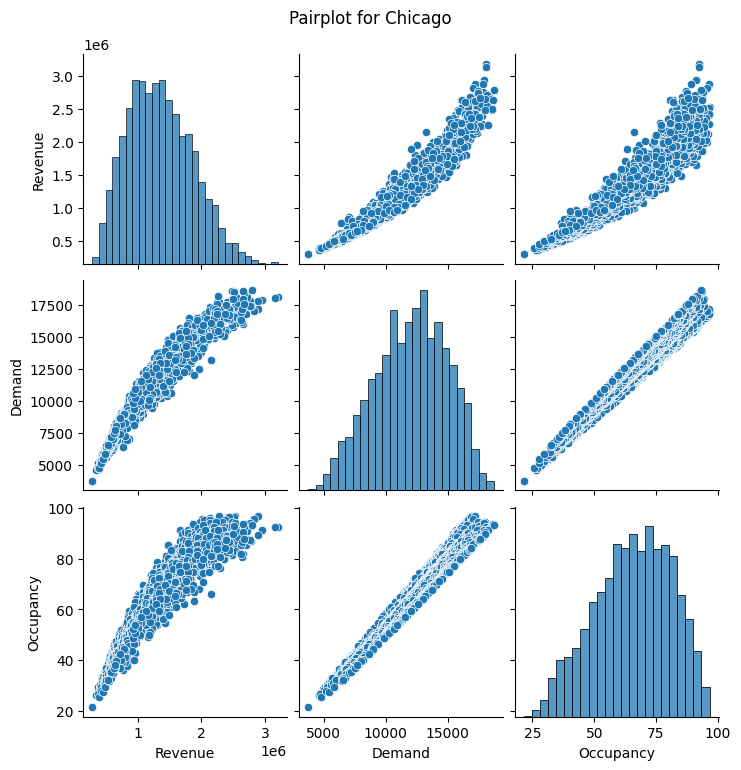

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the pairplot
sns.pairplot(city_data[col_list])
plt.suptitle(f'Pairplot for {city}', y=1.02)
plt.show()


Pairplot shows high correlations between the Occupancy/Demand and also Revenue/Demand and Occupandy/Demand (as we have seen before)

### Check for insights in the data by analyzing yearly, monthly, and weekly patterns

In [38]:
# Normalize the data
scaler = MinMaxScaler()
city_data = pd.DataFrame(scaler.fit_transform(city_data[col_list]), columns=col_list, index=city_data.index)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Extract the year 2018 data
year_2018 = city_data[city_data.index.year == 2018]

# Extract the first month of data (from the first available year)
first_month_start = city_data.index.min().replace(day=1)
first_month_end = (first_month_start + pd.DateOffset(months=1)) - pd.Timedelta(days=1)
first_month = city_data[(city_data.index >= first_month_start) & (city_data.index <= first_month_end)]

# Extract the first week of data (first full week in the dataset)
first_week_start = city_data.index.min()
first_week_end = first_week_start + pd.DateOffset(days=6)
first_week = city_data[(city_data.index >= first_week_start) & (city_data.index <= first_week_end)]

# Create subplots WITHOUT shared x-axes
fig = make_subplots(rows=4, cols=1, shared_xaxes=False, 
                    subplot_titles=("year_2018 Data", "First Month Data", "First Week Data", "Complete Data"))

# First Year Data
fig.add_trace(go.Scatter(x=year_2018.index, y=year_2018['Revenue'], mode='lines', name='Revenue'), row=1, col=1)
fig.add_trace(go.Scatter(x=year_2018.index, y=year_2018['Demand'], mode='lines', name='Demand'), row=1, col=1)
fig.add_trace(go.Scatter(x=year_2018.index, y=year_2018['Occupancy'], mode='lines', name='Occupancy'), row=1, col=1)

# First Month Data
fig.add_trace(go.Scatter(x=first_month.index, y=first_month['Revenue'], mode='lines', name='Revenue'), row=2, col=1)
fig.add_trace(go.Scatter(x=first_month.index, y=first_month['Demand'], mode='lines', name='Demand'), row=2, col=1)
fig.add_trace(go.Scatter(x=first_month.index, y=first_month['Occupancy'], mode='lines', name='Occupancy'), row=2, col=1)

# First Week Data
fig.add_trace(go.Scatter(x=first_week.index, y=first_week['Revenue'], mode='lines', name='Revenue'), row=3, col=1)
fig.add_trace(go.Scatter(x=first_week.index, y=first_week['Demand'], mode='lines', name='Demand'), row=3, col=1)
fig.add_trace(go.Scatter(x=first_week.index, y=first_week['Occupancy'], mode='lines', name='Occupancy'), row=3, col=1)

# Complete Data
fig.add_trace(go.Scatter(x=city_data.index, y=city_data['Revenue'], mode='lines', name='Revenue'), row=4, col=1)
fig.add_trace(go.Scatter(x=city_data.index, y=city_data['Demand'], mode='lines', name='Demand'), row=4, col=1)
fig.add_trace(go.Scatter(x=city_data.index, y=city_data['Occupancy'], mode='lines', name='Occupancy'), row=4, col=1)

# Update layout
fig.update_layout(height=1000, title_text=f"Data for {city}")

fig.show()


## Fast Fourier Transform Analysis of Hotel Performance Metrics

This code performs Fast Fourier Transform (FFT) analysis on hotel time series data to identify cyclical patterns in Revenue, Demand, and Occupancy, visualizing the frequency spectrum of each metric and highlighting the most significant periodic components in days.

In [39]:
from scipy.fft import fft, fftfreq
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Create figure with 3 subplots
fig = make_subplots(rows=3, cols=1, 
                    subplot_titles=("Revenue FFT Spectrum", "Demand FFT Spectrum", "Occupancy FFT Spectrum"),
                    vertical_spacing=0.1)

# Function to compute and plot FFT
def plot_fft(data, column, row, color, n_top_periods=10):
    # Get the values and compute FFT
    y = data[column].values
    N = len(y)
    
    # Compute sample spacing (assuming daily data)
    time_diff = pd.Series(data.index).diff().median().total_seconds()
    T = time_diff / (24 * 3600)  # Convert to days
    
    # Compute FFT
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    magnitudes = 2.0/N * np.abs(yf[:N//2])
    
    # Skip the DC component (0 frequency) and filter frequencies above 0.002
    mask = (xf >= 0.002) & (xf > 0)
    xf_filtered = xf[mask]
    magnitudes_filtered = magnitudes[mask]
    
    # Plot only the filtered frequencies
    fig.add_trace(
        go.Scatter(x=xf_filtered, y=magnitudes_filtered, 
                  mode='lines', name=column, line=dict(color=color)),
        row=row, col=1
    )
    
    # Find top n periods based on magnitude
    top_periods = []
    if len(magnitudes_filtered) > 0:
        # Get indices of top n peaks from the filtered data
        peaks = np.argsort(magnitudes_filtered)[-n_top_periods:]  # Get indices of top peaks
        
        for peak_idx in peaks:
            freq = xf_filtered[peak_idx]
            log_x_adj = np.log10(freq)
            magnitude = magnitudes_filtered[peak_idx]
            period = 1/freq
            
            # Add to list of top periods
            top_periods.append({
                'period': period,
                'frequency': freq,
                'magnitude': magnitude
            })
            
            # Add annotation to plot
            fig.add_annotation(
                x=log_x_adj, y=magnitude,
                text=f"{period:.1f} days",
                showarrow=True, arrowhead=1,
                row=row, col=1
            )
            
    # Sort periods by magnitude (highest first)
    top_periods.sort(key=lambda x: x['magnitude'], reverse=False)
    
    return top_periods

# Plot FFT for each column
peaks_revenue = plot_fft(city_data, 'Revenue', 1, 'blue')
peaks_demand = plot_fft(city_data, 'Demand', 2, 'green')
peaks_occupancy = plot_fft(city_data, 'Occupancy', 3, 'red')

# Update layout
fig.update_layout(
    title_text=f"FFT Spectrum Analysis for {city}",
    height=900,
    showlegend=False
)

# Update x and y axis labels, and set x-axis to log scale
for i in range(1, 4):
    fig.update_xaxes(title_text="Frequency (1/day)", type="log", row=i, col=1)
    fig.update_yaxes(title_text="Magnitude", row=i, col=1)

fig.show()

In [40]:
from scipy import fft
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def fourierExtrapolation(x, n_predict, n_h=10):
    """
    Extrapolate time series data using Fourier transform
    
    Parameters:
    -----------
    x : array-like
        Input time series data
    n_predict : int
        Number of future points to predict
    n_h : int, optional
        Number of harmonics to include (default=10)
        
    Returns:
    --------
    np.array
        Array containing original + predicted values
    """
    n = x.size
    # Ensure x_freqdom and f are defined correctly
    x_freqdom = fft.fft(x)
    f = fft.fftfreq(n)
    
    # Sort frequencies by magnitude (not just frequency value)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]), reverse=True)
    
    # Keep only the most significant components
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    
    # Use only top harmonics (n_h is the number of harmonics to keep)
    for i in indexes[:1 + n_h * 2]:  # *2 because we have complex conjugates
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
        
    return restored_sig

def generate_forecast(city_data, days_to_predict=365, n_harmonics=15):
    """
    Generate Fourier forecasts for time series data
    
    Parameters:
    -----------
    city_data : DataFrame
        Time series data with multiple columns for forecasting
    days_to_predict : int
        Number of days to forecast
    n_harmonics : int
        Number of harmonics to use in Fourier extrapolation
    
    Returns:
    --------
    dict
        Dictionary with forecasted data and dates information
    """
    # Get the last date in the dataset
    last_date = city_data.index[-1]
    
    # Generate future dates
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                periods=days_to_predict)
    
    # Combine historical and future dates
    all_dates = city_data.index.append(future_dates)
    
    # Store forecasts for each column
    forecasts = {}
    
    # For each column, forecast
    for col in col_list:
        # Get the time series data
        data = city_data[col].values
        
        # Apply Fourier extrapolation
        forecast = fourierExtrapolation(data, days_to_predict, n_harmonics)
        
        # Store the forecast
        forecasts[col] = forecast
    
    # Return forecasts and dates
    return {
        'forecasts': forecasts,
        'historical_dates': city_data.index,
        'all_dates': all_dates,
        'last_date': last_date,
        'days_to_predict': days_to_predict
    }

def plot_forecast(forecast_data, city):
    """
    Plot the forecasting results
    
    Parameters:
    -----------
    forecast_data : dict
        Dictionary containing forecast results from generate_forecast
    city : str
        Name of the city for title
    
    Returns:
    --------
    plotly.graph_objs._figure.Figure
        Figure object with the plots
    """
    # Unpack the forecast data
    forecasts = forecast_data['forecasts']
    historical_dates = forecast_data['historical_dates']
    all_dates = forecast_data['all_dates']
    last_date = forecast_data['last_date']
    days_to_predict = forecast_data['days_to_predict']
    
    # Create a figure with subplots
    fig = make_subplots(rows=3, cols=1, 
                        subplot_titles=("Revenue Forecast", "Demand Forecast", "Occupancy Forecast"),
                        vertical_spacing=0.1)
    
    # For each column, plot
    for i, col in enumerate(col_list):
        # Get the original data
        data = city_data[col].values
        
        # Get the forecast
        forecast = forecasts[col]
        
        # Plot historical data
        fig.add_trace(
            go.Scatter(
                x=historical_dates, 
                y=data, 
                mode='lines', 
                name=f'Historical {col}',
                line=dict(color='blue')
            ),
            row=i+1, col=1
        )
        
        # Plot forecasted data
        fig.add_trace(
            go.Scatter(
                x=all_dates, 
                y=forecast, 
                mode='lines', 
                name=f'Forecast {col}',
                line=dict(color='red')
            ),
            row=i+1, col=1
        )
        
        # Add shaded area to indicate forecast region
        fig.add_vrect(
            x0=last_date, 
            x1=all_dates[-1], 
            fillcolor="lightgray", 
            opacity=0.3, 
            layer="below", 
            line_width=0,
            row=i+1, col=1
        )
    
    # Update layout
    fig.update_layout(
        height=900,
        title_text=f"Fourier Forecasting for {city} (Next {days_to_predict} Days)",
        showlegend=True
    )
    
    # Update y-axis titles
    fig.update_yaxes(title_text="Revenue (Normalized)", row=1, col=1)
    fig.update_yaxes(title_text="Demand (Normalized)", row=2, col=1)
    fig.update_yaxes(title_text="Occupancy (Normalized)", row=3, col=1)
    
    return fig

In [41]:
# Generate forecast and plot with multiple parameter sets
forecast_data = generate_forecast(city_data, days_to_predict=365, n_harmonics=15)
plot_forecast(forecast_data, city).show()

## Fourier Forecasting for Long-Term Seasonal Patterns

Testing multiple harmonic configurations (4-20) of the Fast Fourier Transform to identify the optimal model for accurate n-day revenue, demand, and occupancy predictions by systematically evaluating forecast accuracy across different data blocks. (initially n was set to 7)

Setting the forecast window to 365 days (rather than just 7) is appropriate for Fourier transform analysis as it allows the model to properly capture and project complete seasonal cycles in the time series data.

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from plotly.subplots import make_subplots
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

def evaluate_forecast(actual, predicted, metric_names=['MAE', 'MSE', 'RMSE', 'R2']):
    """
    Evaluate forecast with multiple metrics
    
    Parameters:
    -----------
    actual : array-like
        Actual values
    predicted : array-like
        Predicted values
    metric_names : list
        List of metric names to compute
        
    Returns:
    --------
    dict
        Dictionary with metrics
    """
    metrics = {}
    if 'MAE' in metric_names:
        metrics['MAE'] = mean_absolute_error(actual, predicted)
    if 'MSE' in metric_names:
        metrics['MSE'] = mean_squared_error(actual, predicted)
    if 'RMSE' in metric_names:
        # Calculate RMSE manually by taking the square root of MSE
        metrics['RMSE'] = np.sqrt(mean_squared_error(actual, predicted))
    if 'R2' in metric_names:
        metrics['R2'] = r2_score(actual, predicted)
    return metrics

# Test Fourier extrapolation on various blocks of data
def test_forecast_accuracy(data, block_size=1000, forecast_days=7, n_harmonics=15, step=500):
    """
    Test forecast accuracy on various blocks of data
    
    Parameters:
    -----------
    data : DataFrame
        Time series data with multiple columns
    block_size : int
        Size of each block for training
    forecast_days : int
        Number of days to forecast
    n_harmonics : int
        Number of harmonics to use in Fourier extrapolation
    step : int
        Step size between blocks
        
    Returns:
    --------
    dict
        Dictionary with test results
    """
    # Total length of the dataset
    total_length = len(data)
    
    # Ensure block_size + forecast_days <= total_length
    if block_size + forecast_days > total_length:
        raise ValueError("block_size + forecast_days must be <= total_length")
    
    # Calculate starting points for blocks
    start_indices = range(0, total_length - block_size - forecast_days + 1, step)
    
    # Store results
    results = {
        'blocks': [],
        'metrics': {col: {'MAE': [], 'RMSE': [], 'R2': []} for col in col_list},
        'predictions': [],  # Store actual and predicted values for visualization
        'train_data': []   # Store training data for visualization
    }
    
    # Test each block
    for start_idx in start_indices:
        # Get training data
        train_end = start_idx + block_size
        train_data = data.iloc[start_idx:train_end]
        
        # Get test data (actual values for the forecast period)
        test_end = train_end + forecast_days
        test_data = data.iloc[train_end:test_end]
        
        # Generate forecast
        forecast_result = generate_forecast(train_data, forecast_days, n_harmonics)
        forecasts = forecast_result['forecasts']
        
        # Store block information
        block_info = {
            'start_date': train_data.index[0],
            'end_date': train_data.index[-1],
            'forecast_start': test_data.index[0],
            'forecast_end': test_data.index[-1]
        }
        results['blocks'].append(block_info)
        
        # Store training data for visualization
        results['train_data'].append({
            'dates': train_data.index,
            'values': {col: train_data[col].values for col in col_list}
        })
        
        # Store predictions for visualization
        block_predictions = {
            'dates': test_data.index,
            'actual': {},
            'predicted': {},
            'full_fourier': {}
        }
        
        # Evaluate forecast for each column
        for col in col_list:
            # Get predicted values for the test period
            predicted = forecasts[col][-forecast_days:]
            
            # Get actual values
            actual = test_data[col].values
            
            # Store values for visualization
            block_predictions['actual'][col] = actual
            block_predictions['predicted'][col] = predicted
            # Store the entire Fourier fit
            block_predictions['full_fourier'][col] = forecasts[col]
            
            # Calculate metrics
            metrics = evaluate_forecast(actual, predicted)
            
            # Store metrics
            for metric_name in ['MAE', 'RMSE', 'R2']:
                results['metrics'][col][metric_name].append(metrics[metric_name])
        
        results['predictions'].append(block_predictions)
    
    return results

# Run tests with different numbers of harmonics
def test_multiple_harmonics(data, harmonic_list=[10, 50, 100, 500, 1000], block_size=1000, forecast_days=7, step=500):
    """
    Test with different numbers of harmonics
    
    Parameters:
    -----------
    data : DataFrame
        Time series data
    harmonic_list : list
        List of numbers of harmonics to test
    block_size : int
        Size of each block for training
    forecast_days : int
        Number of days to forecast
    step : int
        Step size between blocks
        
    Returns:
    --------
    dict
        Dictionary with test results for each number of harmonics
    """
    results = {}
    
    for n_harmonics in harmonic_list:
        print(f"Testing with {n_harmonics} harmonics...")
        results[n_harmonics] = test_forecast_accuracy(
            data, block_size=block_size, forecast_days=forecast_days, 
            n_harmonics=n_harmonics, step=step
        )
    
    return results

In [43]:
forecast_days = 365

In [44]:
# Run the tests
harmonic_list = [x for x in range(4,20)]
test_results = test_multiple_harmonics(city_data, harmonic_list=harmonic_list, forecast_days=forecast_days,step=10)

Testing with 4 harmonics...
Testing with 5 harmonics...
Testing with 6 harmonics...
Testing with 7 harmonics...
Testing with 8 harmonics...
Testing with 9 harmonics...
Testing with 10 harmonics...
Testing with 11 harmonics...
Testing with 12 harmonics...
Testing with 13 harmonics...
Testing with 14 harmonics...
Testing with 15 harmonics...
Testing with 16 harmonics...
Testing with 17 harmonics...
Testing with 18 harmonics...
Testing with 19 harmonics...


In [46]:
# Plot results
fig = make_subplots(rows=3, cols=1, 
                   subplot_titles=("RMSE by Number of Harmonics", 
                                  "MAE by Number of Harmonics", 
                                  "R2 by Number of Harmonics"),
                   vertical_spacing=0.1)

# Plot metrics for each column and number of harmonics
for i, metric in enumerate(['RMSE', 'MAE', 'R2']):
    for col_idx, col in enumerate(col_list):
        x_values = harmonic_list
        y_values = []
        
        for n_harmonics in harmonic_list:
            # Calculate mean metric across all blocks
            mean_metric = np.mean(test_results[n_harmonics]['metrics'][col][metric])
            y_values.append(mean_metric)
        
        fig.add_trace(
            go.Scatter(x=x_values, y=y_values, mode='lines+markers', name=f"{col} - {metric}"),
            row=i+1, col=1
        )

# Update layout
fig.update_layout(height=800, title_text=f"Forecast Accuracy Metrics for {city}")
fig.update_xaxes(title_text="Number of Harmonics")

# Show the figure
fig.show()

# Find the best number of harmonics for each column
best_harmonics = {}
for col in col_list:
    best_rmse = float('inf')
    best_h = None
    
    for h in harmonic_list:
        mean_rmse = np.mean(test_results[h]['metrics'][col]['RMSE'])
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_h = h
    
    best_harmonics[col] = best_h

print(f"\nBest number of harmonics for each column based on RMSE:")
for col, h in best_harmonics.items():
    print(f"{col}: {h}")

# Create a figure to display predictions vs actual values
pred_fig = make_subplots(rows=3, cols=1, 
                        subplot_titles=[f"{col} - Actual vs Predicted (Best: {best_harmonics[col]} harmonics)" 
                                       for col in col_list],
                        vertical_spacing=0.1)

# Use the best harmonic number for each column
# Take the first two prediction blocks as examples
for col_idx, col in enumerate(col_list):
    best_h = best_harmonics[col]
    # Get the predictions for this column using the best number of harmonics
    # Plot the first two blocks as examples
    for block_idx in np.random.choice(range(len(test_results[best_h]['predictions'])), size=1, replace=False):
        # Get training data
        train_data = test_results[best_h]['train_data'][block_idx]
        train_dates = train_data['dates']
        train_values = train_data['values'][col]
        
        # Get test data
        block_pred = test_results[best_h]['predictions'][block_idx]
        test_dates = block_pred['dates']
        actual = block_pred['actual'][col]
        predicted = block_pred['predicted'][col]

        # NEW: full Fourier fit (length = block_size + forecast_days)
        full_fourier = block_pred['full_fourier'][col]
        full_fourier_dates = train_dates.union(test_dates)
        # Plot training data
        pred_fig.add_trace(
            go.Scatter(x=train_dates, y=train_values, mode='lines', 
                      name=f"Block {block_idx+1} - Training", 
                      line=dict(color='gray', width=1)),
            row=col_idx+1, col=1
        )
        # Plot the entire Fourier fit
        pred_fig.add_trace(
        go.Scatter(
            x=full_fourier_dates, y=full_fourier,
            mode='lines',
            name=f"Block {block_idx+1} - Fourier Fit",
            line=dict(color='green', width=2)
        ),
        row=col_idx+1, col=1
        )
        
        # Plot actual test values
        pred_fig.add_trace(
            go.Scatter(x=test_dates, y=actual, mode='lines+markers', 
                      name=f"Block {block_idx+1} - Actual (Test)", 
                      line=dict(color='blue', width=2)),
            row=col_idx+1, col=1
        )
        
        # Plot predicted values
        pred_fig.add_trace(
            go.Scatter(x=test_dates, y=predicted, mode='lines+markers', 
                      name=f"Block {block_idx+1} - Predicted", 
                      line=dict(color='red', dash='dash', width=2)),
            row=col_idx+1, col=1
        )

        # Add vertical line to separate train and test data
        pred_fig.add_vline(
            x=train_dates[-1], line_width=1, line_dash="dash", line_color="black",
            row=col_idx+1, col=1
        )

# Update layout
pred_fig.update_layout(height=900, title_text=f"Forecast Examples for {city} ({forecast_days}-day forecasts)")
pred_fig.update_layout(legend_title_text="Data Series")

# Update layout to improve readability
pred_fig.for_each_xaxis(lambda x: x.update(title_text="Date"))
pred_fig.for_each_yaxis(lambda y: y.update(title_text="Normalized Value"))

pred_fig.show()


Best number of harmonics for each column based on RMSE:
Revenue: 4
Demand: 4
Occupancy: 4


**Forecasting with Exponential Smoothing and Kalman Filtering**

When forecasting time series data, there are many techniques beyond Fourier-based methods. Two popular alternatives are **Exponential Smoothing** and **Kalman Filtering**. Below is a brief overview of how each method works and how you might apply them to forecast the next 7 days of your city-level time series data.

---

## 1. Exponential Smoothing

**Key Idea:**  
Exponential smoothing is a forecasting technique where recent observations are given relatively more weight (or “importance”) than older observations. It does this through a smoothing parameter (usually denoted by α) that controls how quickly the importance of historical data declines over time.

### Types of Exponential Smoothing

1. **Simple (Single) Exponential Smoothing**  
    - Best for data without a defined trend or strong seasonal pattern.  
    - Forecasts are computed as a weighted average of the current observation and the previous forecast.

2. **Double Exponential Smoothing (Holt’s Method)**  
    - Extends simple exponential smoothing to account for trend in the data.  
    - Maintains a level component and a trend component, each smoothed exponentially.

3. **Triple Exponential Smoothing (Holt-Winters Method)**  
    - Incorporates seasonality on top of level and trend.  
    - Maintains separate components for level, trend, and seasonal effects, each updated exponentially.

### How It Works (Conceptually)

- You choose an α (alpha) between 0 and 1 (or also β and γ if modeling trend and seasonality).  
- The current forecast is updated by taking:
  
  Fᵗ₊₁ = α × (Current Actual Value) + (1 - α) × (Previous Forecast),
  
  (plus additional equations if trend or seasonality is considered).
  
- Because of the exponential factor, the most recent data has a stronger influence on the forecast than data in the distant past.

### Pros and Cons
- **Pros**:  
  - Quick to compute and easy to understand/interpret.  
  - Effective for many time series with relatively stable patterns.  
- **Cons**:  
  - May not capture complex seasonal or cyclical patterns unless you use more advanced variants (double or triple).  
  - If seasonality is not well-defined or changes over time, performance can degrade.

---

## 2. Kalman Filtering

**Key Idea:**  
A Kalman filter handles time series (or signals) by modeling them as a **state-space** process with two equations: one for how the state evolves over time (the “system” or “transition” model) and one for how observations relate to the underlying state (the “observation” or “measurement” model). The Kalman filter then provides an optimal (least squares) estimate of the state at each time step in a recursive manner.

### How It Works (Conceptually)

1. **State Transition Equation**  
    - Describes how the hidden “true” state xₜ transitions to xₜ₊₁, e.g.,  
      xₜ₊₁ = A xₜ + wₜ,  
      where A is a transition matrix, and wₜ is process noise.

2. **Observation Equation**  
    - Describes how the observed data yₜ relates to the hidden state xₜ, e.g.,  
      yₜ = H xₜ + vₜ,  
      where H is an observation matrix, and vₜ is measurement noise.

3. **Recursive Update**  
    - At each time step, the filter:
      1. **Predicts** the state and covariance of the next time step.  
      2. **Updates** these predictions based on the actual observed data to get the new best estimate of the state.

### Kalman Filter for Forecasting

- After each update, you have an updated “best guess” of the true system state.  
- You can use this state—along with the state transition equation—to predict future observations (e.g., the next 7 days).  
- If you have a model that captures both the dynamics of your time series and any external influences (e.g., known holiday effects, day-of-week effects), the Kalman filter can incorporate those in the state vector.

### Pros and Cons
- **Pros**:  
  - Dynamically incorporates new data and uncertainties (both process and measurement noise).  
  - Well-suited for systems where the underlying process has changing states or is influenced by external variables.  
- **Cons**:  
  - Requires formulating a proper state-space model.  
  - Tuning noise covariances can be non-trivial.  
  - More complex to implement compared to straightforward exponential smoothing.

---

## Practical Steps to Implement

1. **Preprocessing**  
    - As with any time series forecasting method, ensure your data is well-prepared (detrended if needed, consistent frequency, handle missing values, etc.).

2. **Model Selection**  
    - Start by choosing a method aligned with your data’s characteristics:
      - **Exponential Smoothing** for simpler patterns or well-defined seasonality.  
      - **Kalman Filter** if you suspect underlying state dynamics, or if you have external factors (control inputs) to include.

3. **Parameter Tuning**  
    - For exponential smoothing, tune α (and β, γ for trend/seasonality).  
    - For a Kalman filter, specify or estimate the process noise covariance (Q) and measurement noise covariance (R). Often done by experimentation or domain knowledge.

4. **Forecast Generation**  
    - For exponential smoothing methods, once fit, use the fitted model to “walk forward” and generate 7-day forecasts.  
    - For a Kalman filter, predict the state 7 steps ahead using the transition equation iteratively, then derive predicted observations from the state.

5. **Evaluation**  
    - Compare predicted values to actual values using RMSE, MAE, MAPE, or R².  
    - Refine parameters as needed.

---

With these methods (alongside your Fourier-based approach), you can explore and compare different forecasting methodologies for your 7-day predictions. Each method has its unique strengths, and your choice may depend on data patterns, external events, and performance requirements.

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from plotly.subplots import make_subplots

# Implementation of Triple Exponential Smoothing (Holt-Winters Method) forecasting
import plotly.graph_objects as go

def hw_forecast(data, forecast_days, seasonal_periods=7, trend='add', seasonal='add', 
                damped_trend=False, smoothing_level=None, smoothing_trend=None, 
                smoothing_seasonal=None):
    """
    Fit Holt-Winters model and generate forecasts
    
    Parameters:
    -----------
    data: pandas.Series
        Time series data to forecast
    forecast_days: int
        Number of days to forecast
    seasonal_periods: int
        Number of observations in a seasonal cycle (e.g., 7 for weekly data)
    trend: str
        Type of trend component ('add' or 'mul')
    seasonal: str
        Type of seasonal component ('add' or 'mul')
    damped_trend: bool
        Whether to use damped trend or not
    smoothing_level, smoothing_trend, smoothing_seasonal: float or None
        Smoothing parameters (α, β, γ) between 0 and 1
        
    Returns:
    --------
    dict
        Dictionary with fitted model and forecast results
    """
    # Check if using multiplicative components and if there are zeros in the data
    if (trend == 'mul' or seasonal == 'mul') and (data <= 0).any():
        # Add a small constant to ensure all values are positive
        epsilon = 0.0001
        data = data + epsilon
        
    # Fit model
    model = ExponentialSmoothing(
        data,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        damped_trend=damped_trend
    )
    
    # Fit the model with provided parameters or let it optimize
    fit_result = model.fit(
        smoothing_level=smoothing_level,
        smoothing_trend=smoothing_trend,
        smoothing_seasonal=smoothing_seasonal,
        optimized=True if all(p is None for p in [smoothing_level, smoothing_trend, smoothing_seasonal]) else False
    )
    
    # Generate forecast
    forecast = fit_result.forecast(steps=forecast_days)
    
    return {
        'model': fit_result,
        'forecast': forecast,
        'params': fit_result.params,
        'fitted_values': fit_result.fittedvalues
    }

def test_hw_forecast_accuracy(data, block_size=1000, forecast_days=7, seasonal_periods=7, 
                           trend='add', seasonal='add', damped_trend=False,
                           smoothing_level=None, smoothing_trend=None, smoothing_seasonal=None,
                           step=500):
    """
    Test Holt-Winters forecast accuracy on various blocks of data
    """
    total_length = len(data)
    
    if block_size + forecast_days > total_length:
        raise ValueError("block_size + forecast_days must be <= total_length")
    
    start_indices = range(0, total_length - block_size - forecast_days + 1, step)
    
    results = {
        'blocks': [],
        'metrics': {col: {'MAE': [], 'RMSE': [], 'R2': []} for col in col_list},
        'predictions': [],
        'train_data': [],
        'fitted_models': []
    }
    
    for start_idx in start_indices:
        train_end = start_idx + block_size
        train_data = data.iloc[start_idx:train_end]
        
        test_end = train_end + forecast_days
        test_data = data.iloc[train_end:test_end]
        
        block_info = {
            'start_date': train_data.index[0],
            'end_date': train_data.index[-1],
            'forecast_start': test_data.index[0],
            'forecast_end': test_data.index[-1]
        }
        results['blocks'].append(block_info)
        
        results['train_data'].append({
            'dates': train_data.index,
            'values': {col: train_data[col].values for col in col_list}
        })
        
        block_predictions = {
            'dates': test_data.index,
            'actual': {},
            'predicted': {},
            'fitted': {}
        }
        
        block_models = {}
        
        for col in col_list:
            # Fit HW model and generate forecast
            hw_result = hw_forecast(
                train_data[col], 
                forecast_days=forecast_days,
                seasonal_periods=seasonal_periods,
                trend=trend,
                seasonal=seasonal,
                damped_trend=damped_trend,
                smoothing_level=smoothing_level,
                smoothing_trend=smoothing_trend,
                smoothing_seasonal=smoothing_seasonal
            )
            
            predicted = hw_result['forecast'].values
            actual = test_data[col].values
            fitted = hw_result['fitted_values']
            
            block_predictions['actual'][col] = actual
            block_predictions['predicted'][col] = predicted
            block_predictions['fitted'][col] = fitted
            block_models[col] = hw_result['model']
            
            # Calculate metrics
            metrics = evaluate_forecast(actual, predicted)
            
            # Store metrics
            for metric_name in ['MAE', 'RMSE', 'R2']:
                results['metrics'][col][metric_name].append(metrics[metric_name])
        
        results['predictions'].append(block_predictions)
        results['fitted_models'].append(block_models)
    
    return results

def test_multiple_hw_params(data, param_grid, block_size=1000, forecast_days=7, step=500):
    """
    Test with different parameter combinations
    """
    results = {}
    
    # Generate parameter combinations
    param_combinations = []
    for trend in param_grid.get('trend', ['add']):
        for seasonal in param_grid.get('seasonal', ['add']):
            for seasonal_periods in param_grid.get('seasonal_periods', [7]):
                for damped_trend in param_grid.get('damped_trend', [False]):
                    params = {
                        'trend': trend,
                        'seasonal': seasonal,
                        'seasonal_periods': seasonal_periods,
                        'damped_trend': damped_trend,
                        'smoothing_level': None,
                        'smoothing_trend': None,
                        'smoothing_seasonal': None
                    }
                    param_combinations.append(params)
    
    for i, params in enumerate(param_combinations):
        param_key = f"params_{i}"
        print(f"Testing with {params}...")
        results[param_key] = test_hw_forecast_accuracy(
            data,
            block_size=block_size,
            forecast_days=forecast_days,
            step=step,
            **params
        )
    
    return results

def plot_hw_results(test_results, city):
    """
    Plot results of Holt-Winters forecasting tests
    """
    # Extract parameter sets and metrics
    param_sets = list(test_results.keys())
    param_details = {}
    
    for i, param_key in enumerate(param_sets):
        # Extract the parameter details from the first fitted model
        first_block = test_results[param_key]['fitted_models'][0]
        first_col = list(first_block.keys())[0]
        params = first_block[first_col].params
        
        # Format parameter details for display
        param_str = f"α={params['smoothing_level']:.2f}, β={params['smoothing_trend']:.2f}, γ={params['smoothing_seasonal']:.2f}"
        if 'damped' in params:
            param_str += f", φ={params['damped']:.2f}"
            
        param_details[param_key] = {
            'label': f"Set {i+1}: {param_str}",
            'params': params
        }
    
    # Create figure for error metrics
    fig = make_subplots(rows=3, cols=1, 
                       subplot_titles=("RMSE by Parameter Set", 
                                      "MAE by Parameter Set", 
                                      "R2 by Parameter Set"),
                       vertical_spacing=0.1)
    
    # Plot metrics for each column and parameter set
    metrics = ['RMSE', 'MAE', 'R2']
    colors = {'Revenue': 'blue', 'Demand': 'green', 'Occupancy': 'red'}
    
    for i, metric in enumerate(metrics):
        for col in col_list:
            x_values = [param_details[param_key]['label'] for param_key in param_sets]
            y_values = []
            
            for param_key in param_sets:
                # Calculate mean metric across all blocks
                mean_metric = np.mean(test_results[param_key]['metrics'][col][metric])
                y_values.append(mean_metric)
            
            fig.add_trace(
                go.Bar(x=x_values, y=y_values, name=f"{col} - {metric}", marker_color=colors[col]),
                row=i+1, col=1
            )
    
    # Update layout
    fig.update_layout(height=1000, title_text=f"Holt-Winters Forecast Accuracy for {city}")
    
    # Find the best parameter set for each column based on RMSE
    best_params = {}
    for col in col_list:
        best_rmse = float('inf')
        best_param_key = None
        
        for param_key in param_sets:
            mean_rmse = np.mean(test_results[param_key]['metrics'][col]['RMSE'])
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_param_key = param_key
        
        best_params[col] = {
            'param_key': best_param_key,
            'label': param_details[best_param_key]['label']
        }
    
    # Plot example forecasts using the best parameters
    pred_fig = make_subplots(rows=3, cols=1, 
                            subplot_titles=[f"{col} - Actual vs Predicted (Best: {best_params[col]['label']})" 
                                          for col in col_list],
                            vertical_spacing=0.1)
    
    # For each column, plot an example forecast
    for col_idx, col in enumerate(col_list):
        best_param_key = best_params[col]['param_key']
        # Pick a random block as an example
        block_idx = np.random.choice(range(len(test_results[best_param_key]['predictions'])))
        
        # Get training data
        train_data = test_results[best_param_key]['train_data'][block_idx]
        train_dates = train_data['dates']
        train_values = train_data['values'][col]
        
        # Get fitted values (in-sample)
        fitted_model = test_results[best_param_key]['fitted_models'][block_idx][col]
        fitted_values = fitted_model.fittedvalues
        
        # Get test data
        block_pred = test_results[best_param_key]['predictions'][block_idx]
        test_dates = block_pred['dates']
        actual = block_pred['actual'][col]
        predicted = block_pred['predicted'][col]
        
        # Plot training data
        pred_fig.add_trace(
            go.Scatter(x=train_dates, y=train_values, mode='lines', 
                      name=f"Block {block_idx+1} - Training", 
                      line=dict(color='gray', width=1)),
            row=col_idx+1, col=1
        )
        
        # Plot fitted values
        pred_fig.add_trace(
            go.Scatter(x=train_dates, y=fitted_values, mode='lines',
                      name=f"Block {block_idx+1} - Fitted Values",
                      line=dict(color='green', width=1.5)),
            row=col_idx+1, col=1
        )
        
        # Plot actual test values
        pred_fig.add_trace(
            go.Scatter(x=test_dates, y=actual, mode='lines+markers', 
                      name=f"Block {block_idx+1} - Actual (Test)", 
                      line=dict(color='blue', width=2)),
            row=col_idx+1, col=1
        )
        
        # Plot predicted values
        pred_fig.add_trace(
            go.Scatter(x=test_dates, y=predicted, mode='lines+markers', 
                      name=f"Block {block_idx+1} - Predicted", 
                      line=dict(color='red', dash='dash', width=2)),
            row=col_idx+1, col=1
        )
        
        # Add vertical line to separate train and test data
        pred_fig.add_vline(
            x=train_dates[-1], line_width=1, line_dash="dash", line_color="black",
            row=col_idx+1, col=1
        )
    
    # Update layout
    pred_fig.update_layout(height=1000, 
                          title_text=f"Holt-Winters Forecast Examples for {city} (7-day forecasts)")
    pred_fig.update_layout(legend_title_text="Data Series")
    
    # Update layout to improve readability
    pred_fig.for_each_xaxis(lambda x: x.update(title_text="Date"))
    pred_fig.for_each_yaxis(lambda y: y.update(title_text="Normalized Value"))
    
    return fig, pred_fig

In [ ]:
# Define parameter grid for testing
hw_param_grid = {
    'trend': ['add'],  # 'add' or 'mul'
    'seasonal': ['add', 'mul'],  # 'add' or 'mul'
    'seasonal_periods': [7, 14, 30, 365],  # Weekly, Bi-weekly, Monthly
    'damped_trend': [False, True]  # Test both regular and damped trends
}

# Run tests with reduced step size to make it faster
hw_test_results = test_multiple_hw_params(city_data, hw_param_grid, forecast_days=7, step=100, block_size=1000)

Testing with {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'damped_trend': False, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'damped_trend': True, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 14, 'damped_trend': False, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 14, 'damped_trend': True, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 30, 'damped_trend': False, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 30, 'damped_trend': True, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 365, 'damped_trend': False, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 365, 'damped_trend': True, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 7, 'damped_trend': False, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 7, 'damped_trend': True, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 14, 'damped_trend': False, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provi

Testing with {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 14, 'damped_trend': True, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 30, 'damped_trend': False, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 30, 'damped_trend': True, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 365, 'damped_trend': False, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency infor

Testing with {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 365, 'damped_trend': True, 'smoothing_level': None, 'smoothing_trend': None, 'smoothing_seasonal': None}...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provi

In [ ]:
# Plot the results
metrics_fig, example_fig = plot_hw_results(hw_test_results, city)
metrics_fig.show()
example_fig.show()

# Compare with Fourier method
best_fourier_rmse = {col: np.min([np.mean(test_results[h]['metrics'][col]['RMSE']) for h in harmonic_list]) for col in col_list}
best_hw_rmse = {col: np.min([np.mean(hw_test_results[pk]['metrics'][col]['RMSE']) for pk in hw_test_results.keys()]) for col in col_list}

comparison_fig = go.Figure()
for col in col_list:
    comparison_fig.add_trace(go.Bar(
        x=['Fourier', 'Holt-Winters'],
        y=[best_fourier_rmse[col], best_hw_rmse[col]],
        name=col
    ))

comparison_fig.update_layout(
    title=f"Best RMSE Comparison: Fourier vs Holt-Winters for {city}",
    xaxis_title="Forecasting Method",
    yaxis_title="RMSE",
    barmode='group'
)
comparison_fig.show()

In [ ]:
pip install pykalman

In [ ]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_kalman_model(seasonalities, process_noise=0.1, measurement_noise=0.1):
    """
    Create a Kalman filter model with given seasonalities
    
    Parameters:
    -----------
    seasonalities: list
        List of seasonal periods to model
    process_noise: float
        Process noise covariance scale
    measurement_noise: float
        Measurement noise covariance scale
        
    Returns:
    --------
    KalmanFilter
        Configured KalmanFilter object
    """
    # Number of seasonal components
    n_seasons = len(seasonalities)
    
    # State transition matrix (identity)
    A = np.eye(n_seasons)
    
    # Observation matrix (ones)
    H = np.ones((1, n_seasons))
    
    # Process noise covariance
    Q = np.eye(n_seasons) * process_noise
    
    # Measurement noise covariance
    R = np.array([[measurement_noise]])
    
    # Initial state and covariance
    initial_state = np.zeros(n_seasons)
    initial_covariance = np.eye(n_seasons)
    
    # Create the Kalman filter
    kf = KalmanFilter(
        transition_matrices=A,
        observation_matrices=H,
        initial_state_mean=initial_state,
        initial_state_covariance=initial_covariance,
        transition_covariance=Q,
        observation_covariance=R
    )
    
    return kf

def kalman_forecast(data, forecast_days, seasonalities, process_noise=0.1, measurement_noise=0.1):
    """
    Fit Kalman filter and generate forecasts
    
    Parameters:
    -----------
    data: pandas.Series
        Time series data to forecast
    forecast_days: int
        Number of days to forecast
    seasonalities: list
        List of seasonal periods to model
    process_noise: float
        Process noise covariance scale
    measurement_noise: float
        Measurement noise covariance scale
        
    Returns:
    --------
    dict
        Dictionary with fitted model and forecast results
    """
    # Create Kalman filter
    kf = create_kalman_model(seasonalities, process_noise, measurement_noise)
    
    # Extract values
    values = data.values
    
    # Fit the model
    state_means, state_covariances = kf.filter(values)
    
    # Generate smoothed estimates
    smoothed_means, _ = kf.smooth(values)
    
    # Generate fitted values
    fitted_values = np.sum(smoothed_means, axis=1)
    
    # Forecast future values
    state_mean_forecast = state_means[-1]
    state_cov_forecast = state_covariances[-1]
    
    forecasted_values = []
    
    for _ in range(forecast_days):
        # Update state without observation
        state_mean_forecast, state_cov_forecast = kf.filter_update(
            state_mean_forecast, state_cov_forecast, observation=None
        )
        # Calculate predicted value
        forecasted_value = np.dot(kf.observation_matrices, state_mean_forecast)[0]
        forecasted_values.append(forecasted_value)
    
    return {
        'model': kf,
        'state_means': state_means,
        'state_covariances': state_covariances,
        'fitted_values': fitted_values,
        'forecast': np.array(forecasted_values),
        'params': {
            'seasonalities': seasonalities,
            'process_noise': process_noise,
            'measurement_noise': measurement_noise
        }
    }

def test_kalman_forecast_accuracy(data, block_size=1000, forecast_days=7, 
                                seasonalities=[7, 30], process_noise=0.1, 
                                measurement_noise=0.1, step=500):
    """
    Test Kalman filter forecast accuracy on various blocks of data
    """
    total_length = len(data)
    
    if block_size + forecast_days > total_length:
        raise ValueError("block_size + forecast_days must be <= total_length")
    
    start_indices = range(0, total_length - block_size - forecast_days + 1, step)
    
    results = {
        'blocks': [],
        'metrics': {col: {'MAE': [], 'RMSE': [], 'R2': []} for col in col_list},
        'predictions': [],
        'train_data': [],
        'fitted_models': []
    }
    
    for start_idx in start_indices:
        train_end = start_idx + block_size
        train_data = data.iloc[start_idx:train_end]
        
        test_end = train_end + forecast_days
        test_data = data.iloc[train_end:test_end]
        
        block_info = {
            'start_date': train_data.index[0],
            'end_date': train_data.index[-1],
            'forecast_start': test_data.index[0],
            'forecast_end': test_data.index[-1]
        }
        results['blocks'].append(block_info)
        
        results['train_data'].append({
            'dates': train_data.index,
            'values': {col: train_data[col].values for col in col_list}
        })
        
        block_predictions = {
            'dates': test_data.index,
            'actual': {},
            'predicted': {},
            'fitted': {}
        }
        
        block_models = {}
        
        for col in col_list:
            # Fit Kalman filter and generate forecast
            kf_result = kalman_forecast(
                train_data[col], 
                forecast_days=forecast_days,
                seasonalities=seasonalities,
                process_noise=process_noise,
                measurement_noise=measurement_noise
            )
            
            predicted = kf_result['forecast']
            actual = test_data[col].values
            fitted = kf_result['fitted_values']
            
            block_predictions['actual'][col] = actual
            block_predictions['predicted'][col] = predicted
            block_predictions['fitted'][col] = fitted
            block_models[col] = kf_result
            
            # Calculate metrics
            metrics = evaluate_forecast(actual, predicted)
            
            # Store metrics
            for metric_name in ['MAE', 'RMSE', 'R2']:
                results['metrics'][col][metric_name].append(metrics[metric_name])
        
        results['predictions'].append(block_predictions)
        results['fitted_models'].append(block_models)
    
    return results

def test_multiple_kalman_params(data, param_grid, block_size=1000, forecast_days=7, step=500):
    """
    Test with different parameter combinations
    """
    results = {}
    
    # Generate parameter combinations
    param_combinations = []
    for seasonality_set in param_grid.get('seasonalities', [[7, 30]]):
        for process_noise in param_grid.get('process_noise', [0.1]):
            for measurement_noise in param_grid.get('measurement_noise', [0.1]):
                params = {
                    'seasonalities': seasonality_set,
                    'process_noise': process_noise,
                    'measurement_noise': measurement_noise
                }
                param_combinations.append(params)
    
    for i, params in enumerate(param_combinations):
        param_key = f"params_{i}"
        print(f"Testing with {params}...")
        results[param_key] = test_kalman_forecast_accuracy(
            data,
            block_size=block_size,
            forecast_days=forecast_days,
            step=step,
            **params
        )
    
    return results

def plot_kalman_results(test_results, city):
    """
    Plot results of Kalman filter forecasting tests
    """
    # Extract parameter sets and metrics
    param_sets = list(test_results.keys())
    param_details = {}
    
    for i, param_key in enumerate(param_sets):
        # Extract the parameter details
        first_block = test_results[param_key]['fitted_models'][0]
        first_col = list(first_block.keys())[0]
        params = first_block[first_col]['params']
        
        # Format parameter details for display
        param_str = f"Q={params['process_noise']}, R={params['measurement_noise']}"
        param_details[param_key] = {
            'label': f"Set {i+1}: {param_str}",
            'params': params
        }
    
    # Create figure for error metrics
    fig = make_subplots(rows=3, cols=1, 
                       subplot_titles=("RMSE by Parameter Set", 
                                      "MAE by Parameter Set", 
                                      "R2 by Parameter Set"),
                       vertical_spacing=0.1)
    
    # Plot metrics for each column and parameter set
    metrics = ['RMSE', 'MAE', 'R2']
    colors = {'Revenue': 'blue', 'Demand': 'green', 'Occupancy': 'red'}
    
    for i, metric in enumerate(metrics):
        for col in col_list:
            x_values = [param_details[param_key]['label'] for param_key in param_sets]
            y_values = []
            
            for param_key in param_sets:
                # Calculate mean metric across all blocks
                mean_metric = np.mean(test_results[param_key]['metrics'][col][metric])
                y_values.append(mean_metric)
            
            fig.add_trace(
                go.Bar(x=x_values, y=y_values, name=f"{col} - {metric}", marker_color=colors[col]),
                row=i+1, col=1
            )
    
    # Update layout
    fig.update_layout(height=1000, title_text=f"Kalman Filter Forecast Accuracy for {city}")
    
    # Find the best parameter set for each column based on RMSE
    best_params = {}
    for col in col_list:
        best_rmse = float('inf')
        best_param_key = None
        
        for param_key in param_sets:
            mean_rmse = np.mean(test_results[param_key]['metrics'][col]['RMSE'])
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_param_key = param_key
        
        best_params[col] = {
            'param_key': best_param_key,
            'label': param_details[best_param_key]['label']
        }
    
    # Plot example forecasts using the best parameters
    pred_fig = make_subplots(rows=3, cols=1, 
                            subplot_titles=[f"{col} - Actual vs Predicted (Best: {best_params[col]['label']})" 
                                          for col in col_list],
                            vertical_spacing=0.1)
    
    # For each column, plot an example forecast
    for col_idx, col in enumerate(col_list):
        best_param_key = best_params[col]['param_key']
        # Pick a random block as an example
        block_idx = np.random.choice(range(len(test_results[best_param_key]['predictions'])))
        
        # Get training data
        train_data = test_results[best_param_key]['train_data'][block_idx]
        train_dates = train_data['dates']
        train_values = train_data['values'][col]
        
        # Get fitted values
        fitted_values = test_results[best_param_key]['predictions'][block_idx]['fitted'][col]
        
        # Get test data
        block_pred = test_results[best_param_key]['predictions'][block_idx]
        test_dates = block_pred['dates']
        actual = block_pred['actual'][col]
        predicted = block_pred['predicted'][col]
        
        # Plot training data
        pred_fig.add_trace(
            go.Scatter(x=train_dates, y=train_values, mode='lines', 
                      name=f"Block {block_idx+1} - Training", 
                      line=dict(color='gray', width=1)),
            row=col_idx+1, col=1
        )
        
        # Plot fitted values
        pred_fig.add_trace(
            go.Scatter(x=train_dates, y=fitted_values, mode='lines',
                      name=f"Block {block_idx+1} - Fitted Values",
                      line=dict(color='green', width=1.5)),
            row=col_idx+1, col=1
        )
        
        # Plot actual test values
        pred_fig.add_trace(
            go.Scatter(x=test_dates, y=actual, mode='lines+markers', 
                      name=f"Block {block_idx+1} - Actual (Test)", 
                      line=dict(color='blue', width=2)),
            row=col_idx+1, col=1
        )
        
        # Plot predicted values
        pred_fig.add_trace(
            go.Scatter(x=test_dates, y=predicted, mode='lines+markers', 
                      name=f"Block {block_idx+1} - Predicted", 
                      line=dict(color='red', dash='dash', width=2)),
            row=col_idx+1, col=1
        )
        
        # Add vertical line to separate train and test data
        pred_fig.add_vline(
            x=train_dates[-1], line_width=1, line_dash="dash", line_color="black",
            row=col_idx+1, col=1
        )
    
    # Update layout
    pred_fig.update_layout(height=1000, 
                          title_text=f"Kalman Filter Forecast Examples for {city} (7-day forecasts)")
    pred_fig.update_layout(legend_title_text="Data Series")
    
    # Update layout to improve readability
    pred_fig.for_each_xaxis(lambda x: x.update(title_text="Date"))
    pred_fig.for_each_yaxis(lambda y: y.update(title_text="Normalized Value"))
    
    return fig, pred_fig

In [ ]:
# Define parameter grid for testing Kalman filter
kalman_param_grid = {
    'seasonalities': [[x["period"] for x in peaks_revenue]],
    'process_noise': [0.01, 0.1, 1.0],
    'measurement_noise': [0.01, 0.1, 1.0]
}


# Run tests with reduced step size for speed
kalman_test_results = test_multiple_kalman_params(
    city_data, 
    kalman_param_grid, 
    forecast_days=7, 
    step=200, 
    block_size=1000
)

In [ ]:
# Plot the results
metrics_fig, example_fig = plot_kalman_results(kalman_test_results, city)
metrics_fig.show()
example_fig.show()

# Compare all three methods: Fourier, Holt-Winters, and Kalman Filter
best_fourier_rmse = {col: np.min([np.mean(test_results[h]['metrics'][col]['RMSE']) for h in harmonic_list]) for col in col_list}
best_hw_rmse = {col: np.min([np.mean(hw_test_results[pk]['metrics'][col]['RMSE']) for pk in hw_test_results.keys()]) for col in col_list}
best_kalman_rmse = {col: np.min([np.mean(kalman_test_results[pk]['metrics'][col]['RMSE']) for pk in kalman_test_results.keys()]) for col in col_list}

comparison_fig = go.Figure()
for col in col_list:
    comparison_fig.add_trace(go.Bar(
        x=['Fourier', 'Holt-Winters', 'Kalman Filter'],
        y=[best_fourier_rmse[col], best_hw_rmse[col], best_kalman_rmse[col]],
        name=col
    ))

comparison_fig.update_layout(
    title=f"Best RMSE Comparison: All Methods for {city}",
    xaxis_title="Forecasting Method",
    yaxis_title="RMSE",
    barmode='group'
)
comparison_fig.show()